In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.cm as cm

PROCESS RAW DATA

In [3]:
file_path = "benchmark_raw_results.csv"  # path to your file
df = pd.read_csv(file_path, sep=';')

# -------------------------
# 1. Convert numeric columns
# -------------------------
numeric_cols = [
    'execution_time_ms',
    'alloc_mem_mb',
    'peak_mem_mb',
    'cpu_usage_percent'
]

for col in numeric_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(',', '.', regex=False)
        .apply(pd.to_numeric, errors='coerce')
    )

# -------------------------
# 2. Remove warm-up runs
# -------------------------
df = df[df['warm-up'] != 1]

# -------------------------
# 3. Drop unused columns
# -------------------------
columns_to_drop = ['run_id', 'timestamp', 'warm-up', 'notes']
df = df.drop(columns=columns_to_drop)

# -------------------------
# 4. Aggregation
# -------------------------
group_cols = ['matrix_size', 'vectorization', 'threads']

agg_dict = {
    'execution_time_ms': ['mean', 'median', 'std'],
    'alloc_mem_mb': ['mean', 'median', 'std'],
    'peak_mem_mb': ['mean', 'median', 'std'],
    'cpu_usage_percent': ['mean', 'median', 'std']
}

agg_df = df.groupby(group_cols).agg(agg_dict).reset_index()

# Flatten MultiIndex columns
agg_df.columns = ['_'.join(filter(None, col)).rstrip('_') for col in agg_df.columns]

# -------------------------
# 5. Round numeric columns to 2 decimals
# -------------------------
numeric_cols_agg = [col for col in agg_df.columns if col not in group_cols]
agg_df[numeric_cols_agg] = agg_df[numeric_cols_agg].round(2)

# -------------------------
# 6. Save aggregated results
# -------------------------
agg_df.to_csv('benchmark_aggregated_results.csv', index=False, sep=';')

print("Aggregated data saved as benchmark_aggregated_results.csv")
agg_df


Aggregated data saved as benchmark_aggregated_results.csv


,matrix_size,vectorization,threads,execution_time_ms_mean,execution_time_ms_median,execution_time_ms_std,alloc_mem_mb_mean,alloc_mem_mb_median,alloc_mem_mb_std,peak_mem_mb_mean,peak_mem_mb_median,peak_mem_mb_std,cpu_usage_percent_mean,cpu_usage_percent_median,cpu_usage_percent_std
0,64,none,1,0.14,0.12,0.06,1.94,1.94,0.0,0.13,0.00,0.51,2.78,0.00,3.82
1,64,none,2,0.21,0.16,0.17,1.97,1.97,0.0,0.27,0.00,0.71,4.02,4.62,2.97
2,64,none,4,0.20,0.19,0.06,1.97,1.97,0.0,0.40,0.00,0.83,2.47,0.00,3.44
3,64,none,6,0.18,0.16,0.05,1.97,1.97,0.0,0.27,0.00,0.71,2.78,0.00,3.42
4,64,none,8,0.19,0.17,0.05,1.97,1.97,0.0,0.00,0.00,0.00,3.70,4.63,3.98
5,64,none,10,0.24,0.21,0.10,1.97,1.97,0.0,0.27,0.00,0.71,2.47,0.00,3.44
6,64,simd,1,0.10,0.10,0.01,2.09,2.09,0.0,0.00,0.00,0.00,5.27,4.63,4.95
7,64,simd,2,0.33,0.33,0.04,2.09,2.09,0.0,0.14,0.00,0.55,2.67,0.00,3.67
8,64,simd,4,0.23,0.20,0.06,2.09,2.09,0.0,0.85,0.00,1.08,3.71,4.63,3.60
9,64,simd,6,0.21,0.19,0.08,2.09,2.09,0.0,0.28,0.00,0.75,3.08,0.00,3.77


GENERATE GRAPHS

In [4]:
def plot_lines(
    x: list,
    y: list,
    file_name: str,
    labels: list[str],
    title: str,
    xlabel: str,
    ylabel: str,
    figsize=(8,5),
    markers=True,
    line_colors: list = None,  # optional colors
    log_scale=False  # new parameter for logarithmic y-axis
):
    """
    Plot multiple lines on a single graph with x values as ticks, and save it to a file.

    Parameters:
        x (list): X-axis values
        y (list of lists): Each inner list is a line's Y-axis values
        labels (list of str): Labels for each line
        title (str): Graph title
        xlabel (str): X-axis label
        ylabel (str): Y-axis label
        figsize (tuple, optional): Figure size
        markers (bool, optional): Show markers on data points
        file_name (str): Name of the file to save the plot in './graphs'
        line_colors (list, optional): List of colors for each line
        log_scale (bool, optional): Use logarithmic scale for y-axis
    """
    plt.figure(figsize=figsize)

    # Plot each line
    for i, y_values in enumerate(y):
        label = labels[i] if labels is not None else f"Line {i+1}"
        color = line_colors[i] if line_colors is not None and i < len(line_colors) else None
        if markers:
            plt.plot(x, y_values, marker='o', label=label, color=color)
        else:
            plt.plot(x, y_values, label=label, color=color)

    # Set x-axis ticks to match x values
    plt.xticks(x, x, rotation=45)

    # Set logarithmic y-axis if requested
    if log_scale:
        plt.yscale('log')

    plt.grid(True, linestyle='--', alpha=0.5)
    if labels:
        plt.legend()
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

    plt.tight_layout()

    # Save plot
    os.makedirs('./graphs', exist_ok=True)
    full_path = os.path.join('./graphs', file_name)
    plt.savefig(full_path)
    print(f"Plot saved to {full_path}")

    plt.show()


Execution time

Plot saved to ./graphs\speedup_execution_time_ms_mean_simd.png


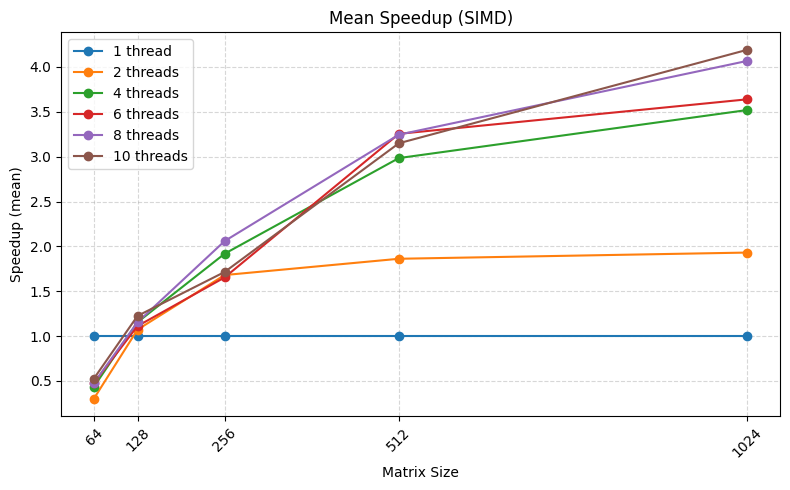

Plot saved to ./graphs\speedup_execution_time_ms_median_simd.png


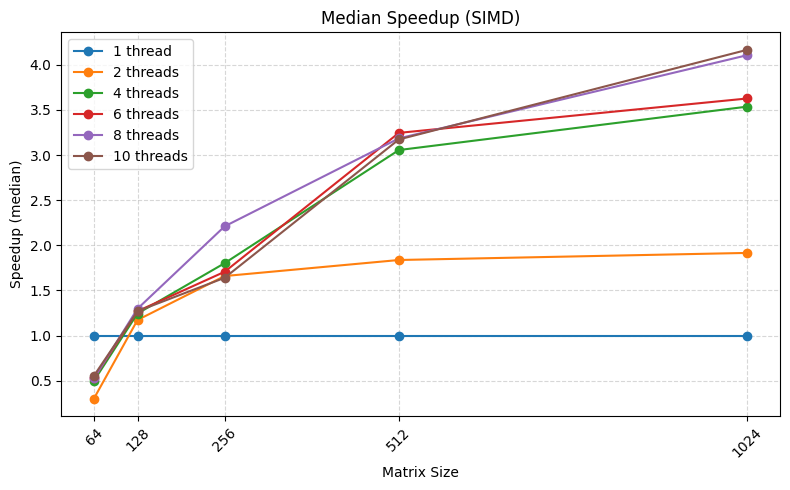

Plot saved to ./graphs\speedup_execution_time_ms_std_simd.png


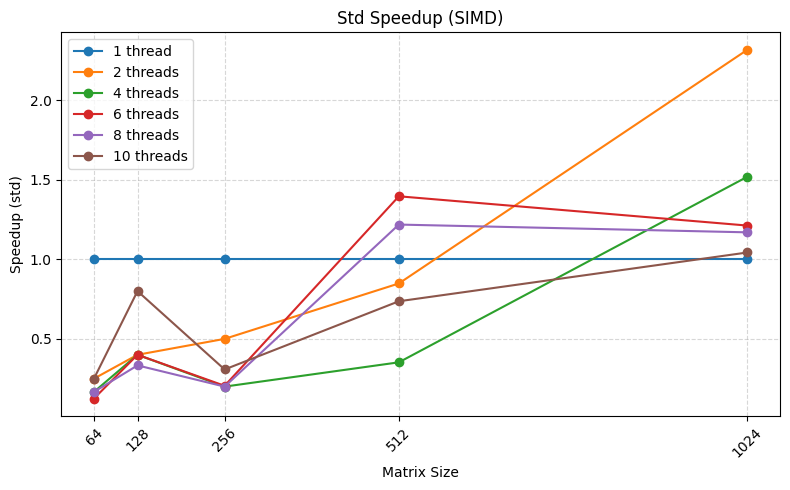

{'execution_time_ms_mean':     matrix_size  threads   speedup
 0            64        1  1.000000
 1           128        1  1.000000
 2           256        1  1.000000
 3           512        1  1.000000
 4          1024        1  1.000000
 5            64        2  0.303030
 6           128        2  1.071429
 7           256        2  1.680000
 8           512        2  1.861505
 9          1024        2  1.930748
 10           64        4  0.434783
 11          128        4  1.153846
 12          256        4  1.917808
 13          512        4  2.984266
 14         1024        4  3.520076
 15           64        6  0.476190
 16          128        6  1.111111
 17          256        6  1.653543
 18          512        6  3.254528
 19         1024        6  3.639481
 20           64        8  0.476190
 21          128        8  1.153846
 22          256        8  2.058824
 23          512        8  3.245247
 24         1024        8  4.067889
 25           64       10  0.526316
 2

In [5]:
# Preparar variables
matrix_sizes = sorted(agg_df['matrix_size'].unique())
thread_counts = sorted(agg_df['threads'].unique())

metrics = ['execution_time_ms_mean', 'execution_time_ms_median', 'execution_time_ms_std']
titles = ['Mean Speedup (SIMD)', 'Median Speedup (SIMD)', 'Std Speedup (SIMD)']
y_labels = ['Speedup (mean)', 'Speedup (median)', 'Speedup (std)']

# Diccionario para guardar una tabla por cada métrica
tables_by_metric = {}

# Generar un gráfico por cada métrica, solo con SIMD
for metric, title, y_label in zip(metrics, titles, y_labels):

    rows = []   # <-- tabla para ESTA métrica

    y_lines = []
    labels = []

    for t in thread_counts:
        y_values = []

        for size in matrix_sizes:

            df_size = agg_df[
                (agg_df['matrix_size'] == size) &
                (agg_df['vectorization'] == 'simd')
            ]

            # Baseline (1 thread)
            t1_time = df_size[df_size['threads'] == 1][metric].mean()

            # Tiempo actual
            tN_time = df_size[df_size['threads'] == t][metric].mean()

            speedup = t1_time / tN_time
            y_values.append(speedup)

            # Agregar fila a ESTA tabla
            rows.append({
                "matrix_size": size,
                "threads": t,
                "speedup": speedup
            })

        y_lines.append(y_values)
        labels.append(f"{t} thread{'s' if t > 1 else ''}")

    # Guardar la tabla en un DataFrame
    tables_by_metric[metric] = pd.DataFrame(rows)

    # Graficar
    plot_lines(
        x=matrix_sizes,
        y=y_lines,
        file_name=f"speedup_{metric}_simd.png",
        labels=labels,
        title=title,
        xlabel="Matrix Size",
        ylabel=y_label,
        markers=True
    )

# ---> tables_by_metric now contains:
#     tables_by_metric['execution_time_ms_mean']
#     tables_by_metric['execution_time_ms_median']
#     tables_by_metric['execution_time_ms_std']
tables_by_metric


Plot saved to ./graphs\speedup_execution_time_ms_mean_without_simd.png


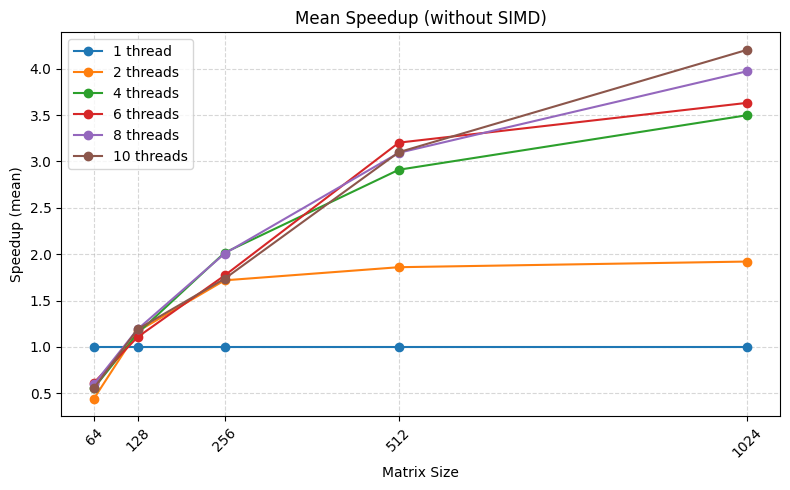

Plot saved to ./graphs\speedup_execution_time_ms_median_without_simd.png


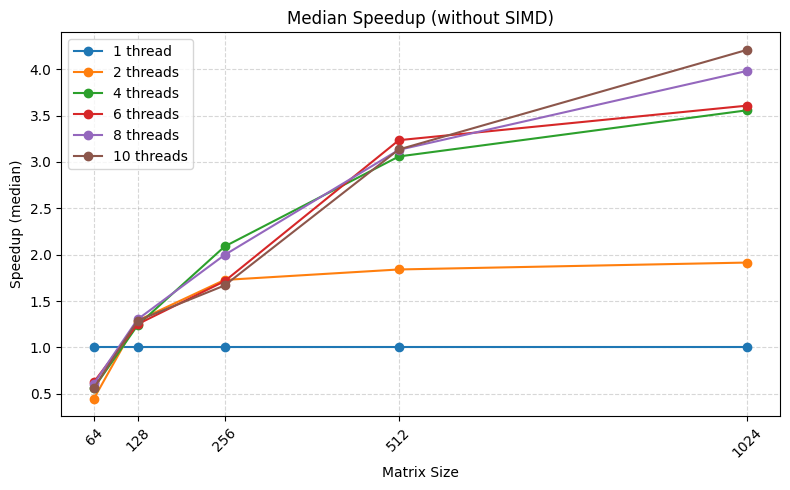

Plot saved to ./graphs\speedup_execution_time_ms_std_without_simd.png


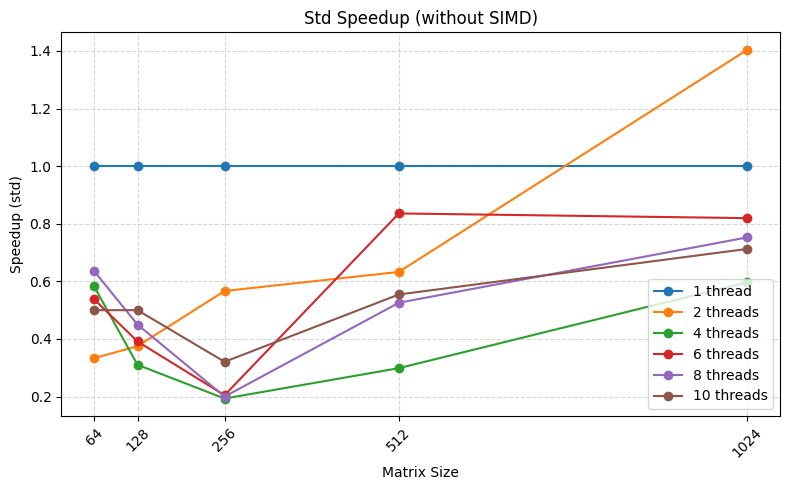

{'execution_time_ms_mean':     matrix_size  threads   speedup
 0            64        1  1.000000
 1           128        1  1.000000
 2           256        1  1.000000
 3           512        1  1.000000
 4          1024        1  1.000000
 5            64        2  0.444444
 6           128        2  1.168224
 7           256        2  1.718504
 8           512        2  1.860005
 9          1024        2  1.920960
 10           64        4  0.558140
 11          128        4  1.146789
 12          256        4  2.016166
 13          512        4  2.910423
 14         1024        4  3.498477
 15           64        6  0.615385
 16          128        6  1.106195
 17          256        6  1.770791
 18          512        6  3.202509
 19         1024        6  3.631460
 20           64        8  0.600000
 21          128        8  1.190476
 22          256        8  2.006897
 23          512        8  3.093033
 24         1024        8  3.972583
 25           64       10  0.558140
 2

In [6]:
# Preparar variables
matrix_sizes = sorted(agg_df['matrix_size'].unique())
thread_counts = sorted(agg_df['threads'].unique())

metrics = ['execution_time_ms_mean', 'execution_time_ms_median', 'execution_time_ms_std']
titles = ['Mean Speedup (without SIMD)', 'Median Speedup (without SIMD)', 'Std Speedup (without SIMD)']
y_labels = ['Speedup (mean)', 'Speedup (median)', 'Speedup (std)']

# Diccionario para guardar una tabla para cada métrica
tables_by_metric_no_simd = {}

# Generar un gráfico por cada métrica
for metric, title, y_label in zip(metrics, titles, y_labels):

    rows = []  # <-- Tabla para esta métrica

    y_lines = []
    labels = []

    for t in thread_counts:
        y_values = []

        for size in matrix_sizes:

            # Baseline (1 thread)
            t1_time = agg_df[
                (agg_df['matrix_size'] == size) &
                (agg_df['threads'] == 1)
            ][metric].mean()

            # Tiempo actual de t hilos
            tN_time = agg_df[
                (agg_df['matrix_size'] == size) &
                (agg_df['threads'] == t)
            ][metric].mean()

            speedup = t1_time / tN_time
            y_values.append(speedup)

            # Agregar fila en la tabla de esta métrica
            rows.append({
                "matrix_size": size,
                "threads": t,
                "speedup": speedup
            })

        y_lines.append(y_values)
        labels.append(f"{t} thread{'s' if t > 1 else ''}")

    # Guardar tabla de esta métrica
    tables_by_metric_no_simd[metric] = pd.DataFrame(rows)

    # Graficar
    plot_lines(
        x=matrix_sizes,
        y=y_lines,
        file_name=f"speedup_{metric}_without_simd.png",
        labels=labels,
        title=title,
        xlabel="Matrix Size",
        ylabel=y_label,
        markers=True
    )

# Devuelve todas las tablas
tables_by_metric_no_simd


Plot saved to ./graphs\speedup_mean_with_baseline.png


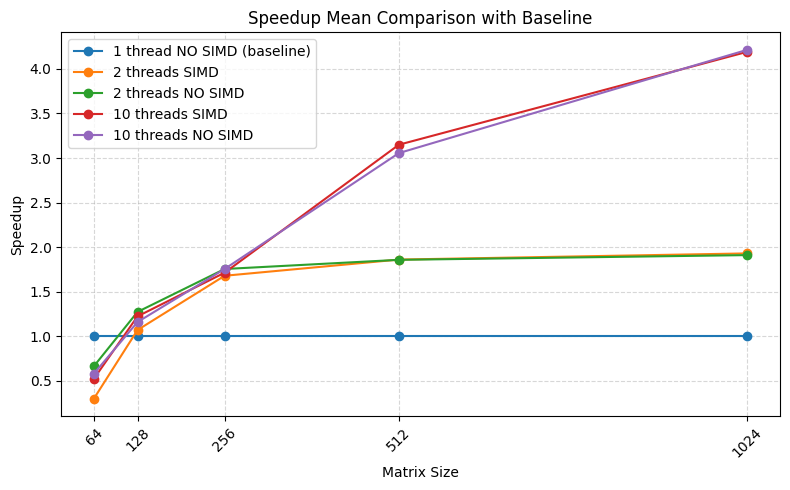

   matrix_size  baseline_1thread_none  speedup_simd_2  speedup_none_2  \
0           64                    1.0        0.303030        0.666667   
1          128                    1.0        1.071429        1.274510   
2          256                    1.0        1.680000        1.755814   
3          512                    1.0        1.861505        1.858636   
4         1024                    1.0        1.930748        1.911709   

   speedup_simd_10  speedup_none_10  
0         0.526316         0.583333  
1         1.224490         1.160714  
2         1.714286         1.755814  
3         3.149446         3.055646  
4         4.191819         4.214402  


In [23]:
# Preparar variables
matrix_sizes = sorted(agg_df['matrix_size'].unique())

metric = "execution_time_ms_mean"

speedup_simd_2 = []
speedup_none_2 = []
speedup_simd_10 = []
speedup_none_10 = []
baseline_1thread_none = []

for size in matrix_sizes:

    # Baseline: 1 thread, no SIMD
    df_none = agg_df[(agg_df["matrix_size"] == size) & (agg_df["vectorization"] == "none")]
    t1_none = df_none[df_none["threads"] == 1][metric].mean()
    baseline_1thread_none.append(1.0)  # speedup baseline is always 1

    # SIMD
    df_simd = agg_df[(agg_df["matrix_size"] == size) & (agg_df["vectorization"] == "simd")]
    t1_simd = df_simd[df_simd["threads"] == 1][metric].mean()
    t2_simd  = df_simd[df_simd["threads"] == 2][metric].mean()
    t10_simd = df_simd[df_simd["threads"] == 10][metric].mean()
    speedup_simd_2.append(t1_simd / t2_simd)
    speedup_simd_10.append(t1_simd / t10_simd)

    # NONE
    t2_none  = df_none[df_none["threads"] == 2][metric].mean()
    t10_none = df_none[df_none["threads"] == 10][metric].mean()
    speedup_none_2.append(t1_none / t2_none)
    speedup_none_10.append(t1_none / t10_none)

# ----------------------------------------------------------------------
# Graficar comparación combinada con baseline
# ----------------------------------------------------------------------

plot_lines(
    x=matrix_sizes,
    y=[
        baseline_1thread_none,
        speedup_simd_2,
        speedup_none_2,
        speedup_simd_10,
        speedup_none_10
    ],
    labels=[
        "1 thread NO SIMD (baseline)",
        "2 threads SIMD",
        "2 threads NO SIMD",
        "10 threads SIMD",
        "10 threads NO SIMD"
    ],
    file_name="speedup_mean_with_baseline.png",
    title="Speedup Mean Comparison with Baseline",
    xlabel="Matrix Size",
    ylabel="Speedup",
    markers=True
)

# ----------------------------------------------------------------------
# Tabla con los datos usados en la gráfica
# ----------------------------------------------------------------------

comparison_table = pd.DataFrame({
    "matrix_size": matrix_sizes,
    "baseline_1thread_none": baseline_1thread_none,
    "speedup_simd_2": speedup_simd_2,
    "speedup_none_2": speedup_none_2,
    "speedup_simd_10": speedup_simd_10,
    "speedup_none_10": speedup_none_10
})

print(comparison_table)


Memory usage

Plot saved to ./graphs\alloc_mem_mb_mean_absolute_simd.png


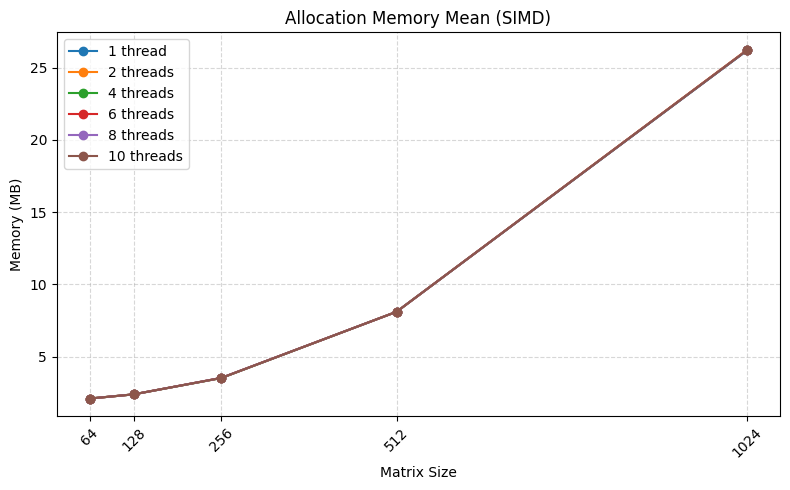

Plot saved to ./graphs\alloc_mem_mb_median_absolute_simd.png


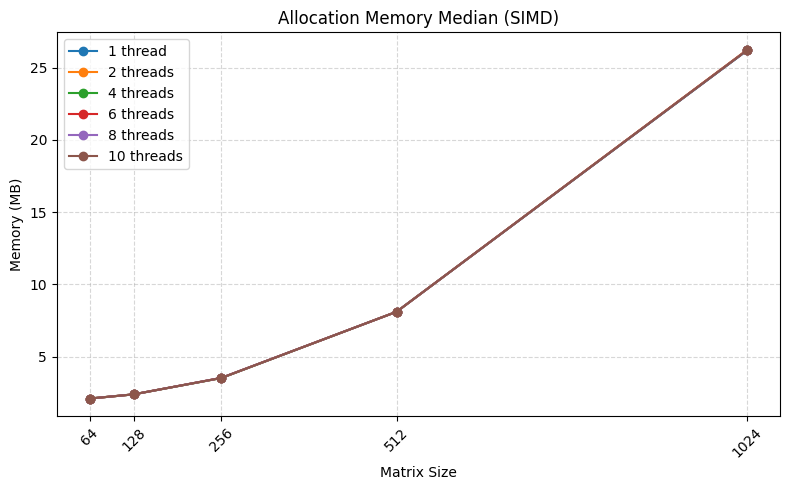

Plot saved to ./graphs\alloc_mem_mb_std_absolute_simd.png


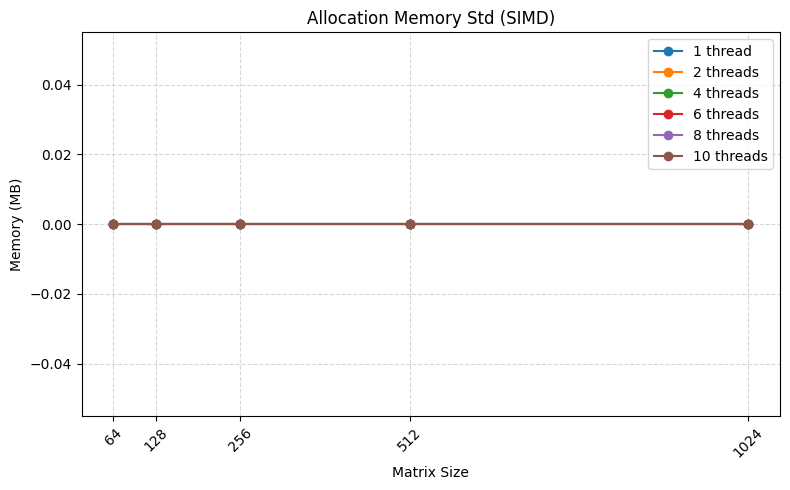

{'alloc_mem_mb_mean':     matrix_size  threads  memory_value
 0            64        1          2.09
 1           128        1          2.38
 2           256        1          3.51
 3           512        1          8.10
 4          1024        1         26.20
 5            64        2          2.09
 6           128        2          2.38
 7           256        2          3.51
 8           512        2          8.10
 9          1024        2         26.25
 10           64        4          2.09
 11          128        4          2.38
 12          256        4          3.51
 13          512        4          8.10
 14         1024        4         26.22
 15           64        6          2.09
 16          128        6          2.38
 17          256        6          3.52
 18          512        6          8.10
 19         1024        6         26.23
 20           64        8          2.09
 21          128        8          2.38
 22          256        8          3.52
 23          512   

In [8]:
# Preparar variables
matrix_sizes = sorted(agg_df['matrix_size'].unique())
thread_counts = sorted(agg_df['threads'].unique())

# Columnas de memoria de asignación que queremos graficar
metrics = ['alloc_mem_mb_mean', 'alloc_mem_mb_median', 'alloc_mem_mb_std']
titles = ['Allocation Memory Mean (SIMD)', 'Allocation Memory Median (SIMD)', 'Allocation Memory Std (SIMD)']
y_labels = ['Memory (MB)'] * len(metrics)

# Diccionario para guardar una tabla por cada métrica
tables_by_metric = {}

# Graficar cada métrica de memoria de asignación con SIMD
for metric, title, y_label in zip(metrics, titles, y_labels):

    rows = []  # <-- tabla para ESTA métrica

    y_lines = []
    labels = []

    for t in thread_counts:
        y_values = []

        for size in matrix_sizes:
            # Filtrar por tamaño, threads y SIMD
            mem_value = agg_df[
                (agg_df['matrix_size'] == size) &
                (agg_df['threads'] == t) &
                (agg_df['vectorization'] == 'simd')
            ][metric].mean()  # promedio si hay múltiples registros

            y_values.append(mem_value)

            # ---- agregar fila a la tabla ----
            rows.append({
                "matrix_size": size,
                "threads": t,
                "memory_value": mem_value
            })

        y_lines.append(y_values)
        labels.append(f"{t} thread{'s' if t > 1 else ''}")

    # Guardar tabla en el diccionario
    tables_by_metric[metric] = pd.DataFrame(rows)

    # Graficar
    plot_lines(
        x=matrix_sizes,
        y=y_lines,
        file_name=f"{metric}_absolute_simd.png",
        labels=labels,
        title=title,
        xlabel="Matrix Size",
        ylabel=y_label,
        markers=True
    )

# Al final, tables_by_metric contiene una tabla por métrica:
# - tables_by_metric['alloc_mem_mb_mean']
# - tables_by_metric['alloc_mem_mb_median']
# - tables_by_metric['alloc_mem_mb_std']
tables_by_metric


Plot saved to ./graphs\peak_mem_mb_mean_absolute_simd.png


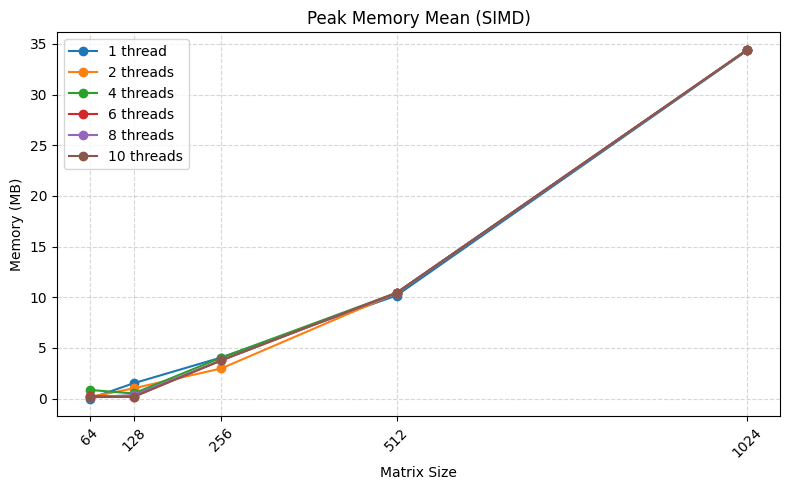

Plot saved to ./graphs\peak_mem_mb_median_absolute_simd.png


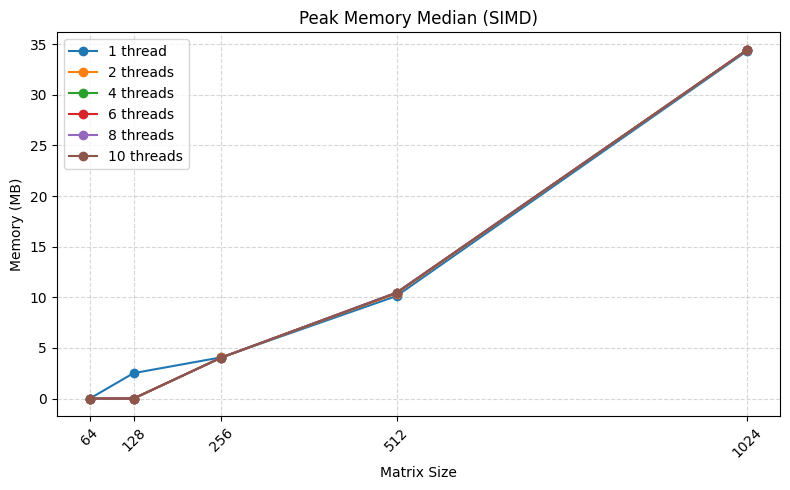

Plot saved to ./graphs\peak_mem_mb_std_absolute_simd.png


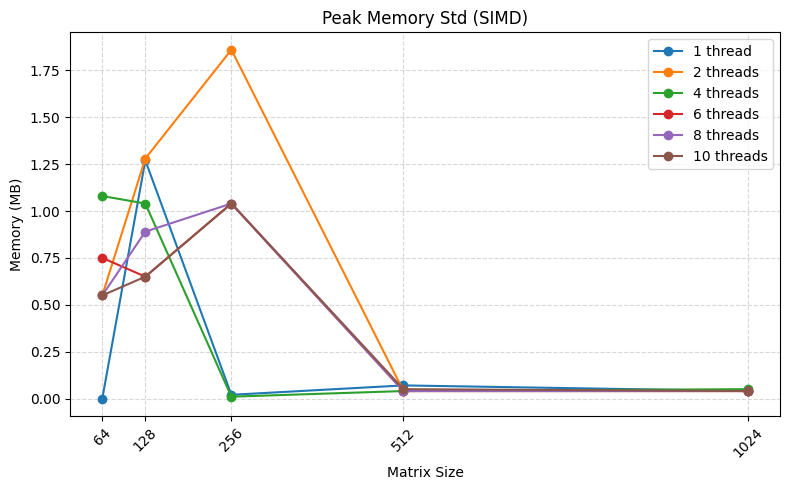

{'peak_mem_mb_mean':     matrix_size  threads  memory_value
 0            64        1          0.00
 1           128        1          1.51
 2           256        1          4.05
 3           512        1         10.17
 4          1024        1         34.36
 5            64        2          0.14
 6           128        2          1.01
 7           256        2          2.97
 8           512        2         10.41
 9          1024        2         34.42
 10           64        4          0.85
 11          128        4          0.50
 12          256        4          4.04
 13          512        4         10.43
 14         1024        4         34.39
 15           64        6          0.28
 16          128        6          0.17
 17          256        6          3.77
 18          512        6         10.43
 19         1024        6         34.42
 20           64        8          0.14
 21          128        8          0.34
 22          256        8          3.77
 23          512    

In [9]:
# Preparar variables
matrix_sizes = sorted(agg_df['matrix_size'].unique())
thread_counts = sorted(agg_df['threads'].unique())

# Columnas de peak memory que queremos graficar
metrics = ['peak_mem_mb_mean', 'peak_mem_mb_median', 'peak_mem_mb_std']
titles = ['Peak Memory Mean (SIMD)', 'Peak Memory Median (SIMD)', 'Peak Memory Std (SIMD)']
y_labels = ['Memory (MB)'] * len(metrics)

# Diccionario para guardar una tabla por cada métrica (una por gráfico)
tables_by_metric = {}

# Graficar cada métrica de peak memory con SIMD
for metric, title, y_label in zip(metrics, titles, y_labels):

    rows = []    # Tabla específica para esta métrica
    y_lines = []
    labels = []

    for t in thread_counts:
        y_values = []

        for size in matrix_sizes:
            # Filtrar por tamaño, threads y SIMD
            mem_value = agg_df[
                (agg_df['matrix_size'] == size) &
                (agg_df['threads'] == t) &
                (agg_df['vectorization'] == 'simd')
            ][metric].mean()

            y_values.append(mem_value)

            # Agregar fila a la tabla de esta métrica
            rows.append({
                "matrix_size": size,
                "threads": t,
                "memory_value": mem_value
            })

        y_lines.append(y_values)
        labels.append(f"{t} thread{'s' if t > 1 else ''}")

    # Guardar tabla en DataFrame (sin importar nada extra, ya tienes pandas en el entorno)
    tables_by_metric[metric] = agg_df.__class__(rows)

    # Llamar a la función plot_lines
    plot_lines(
        x=matrix_sizes,
        y=y_lines,
        file_name=f"{metric}_absolute_simd.png",
        labels=labels,
        title=title,
        xlabel="Matrix Size",
        ylabel=y_label,
        markers=True
    )

# Resultado: un DataFrame por métrica
tables_by_metric


Plot saved to ./graphs\alloc_mem_mb_mean_absolute_without_simd.png


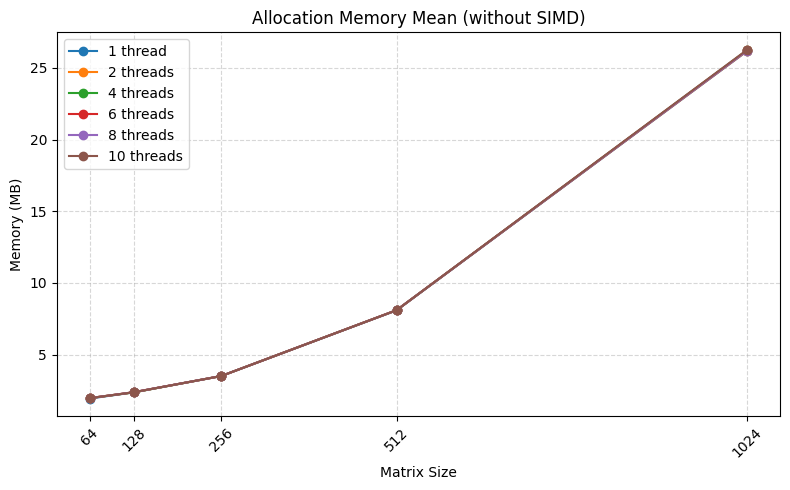

Plot saved to ./graphs\alloc_mem_mb_median_absolute_without_simd.png


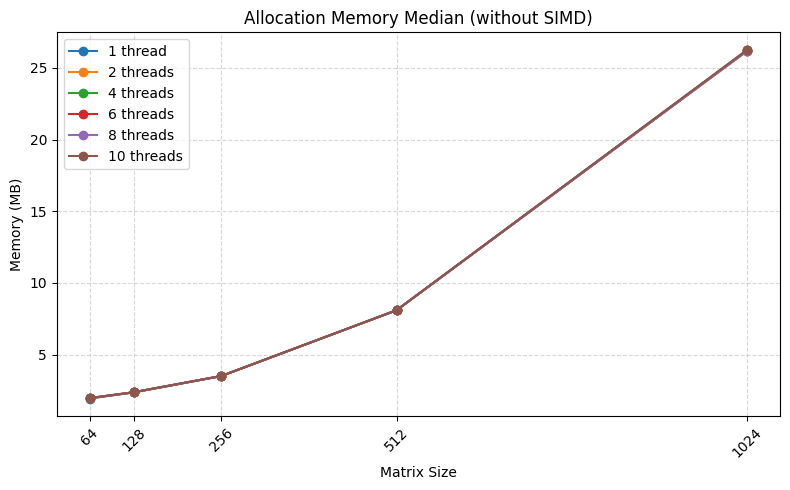

Plot saved to ./graphs\alloc_mem_mb_std_absolute_without_simd.png


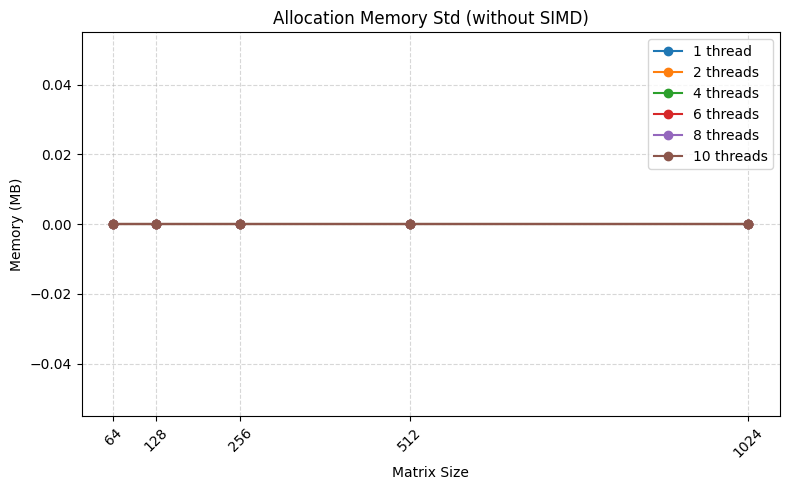

{'alloc_mem_mb_mean':     matrix_size  threads  memory_value
 0            64        1          1.94
 1           128        1          2.37
 2           256        1          3.51
 3           512        1          8.09
 4          1024        1         26.17
 5            64        2          1.97
 6           128        2          2.37
 7           256        2          3.51
 8           512        2          8.10
 9          1024        2         26.18
 10           64        4          1.97
 11          128        4          2.37
 12          256        4          3.51
 13          512        4          8.10
 14         1024        4         26.23
 15           64        6          1.97
 16          128        6          2.38
 17          256        6          3.51
 18          512        6          8.10
 19         1024        6         26.22
 20           64        8          1.97
 21          128        8          2.38
 22          256        8          3.51
 23          512   

In [10]:
# Preparar variables
matrix_sizes = sorted(agg_df['matrix_size'].unique())
thread_counts = sorted(agg_df['threads'].unique())

# Columnas de memoria de asignación que queremos graficar
metrics = ['alloc_mem_mb_mean', 'alloc_mem_mb_median', 'alloc_mem_mb_std']
titles = ['Allocation Memory Mean (without SIMD)', 'Allocation Memory Median (without SIMD)', 'Allocation Memory Std (without SIMD)']
y_labels = ['Memory (MB)'] * len(metrics)

# Diccionario para guardar una tabla por cada métrica
tables_by_metric = {}

# Graficar cada métrica de memoria de asignación sin SIMD
for metric, title, y_label in zip(metrics, titles, y_labels):

    rows = []   # tabla para ESTA métrica
    y_lines = []
    labels = []

    for t in thread_counts:
        y_values = []

        for size in matrix_sizes:

            # Filtrar por tamaño, threads y sin SIMD
            mem_value = agg_df[
                (agg_df['matrix_size'] == size) &
                (agg_df['threads'] == t) &
                (agg_df['vectorization'] == 'none')
            ][metric].mean()

            y_values.append(mem_value)

            # Agregar fila a la tabla de esta métrica
            rows.append({
                "matrix_size": size,
                "threads": t,
                "memory_value": mem_value
            })

        y_lines.append(y_values)
        labels.append(f"{t} thread{'s' if t > 1 else ''}")

    # Crear DataFrame con la tabla de este gráfico
    tables_by_metric[metric] = pd.DataFrame(rows)

    # Graficar
    plot_lines(
        x=matrix_sizes,
        y=y_lines,
        file_name=f"{metric}_absolute_without_simd.png",
        labels=labels,
        title=title,
        xlabel="Matrix Size",
        ylabel=y_label,
        markers=True
    )

# Devolver diccionario con todas las tablas
tables_by_metric


Plot saved to ./graphs\peak_mem_mb_mean_absolute_without_simd.png


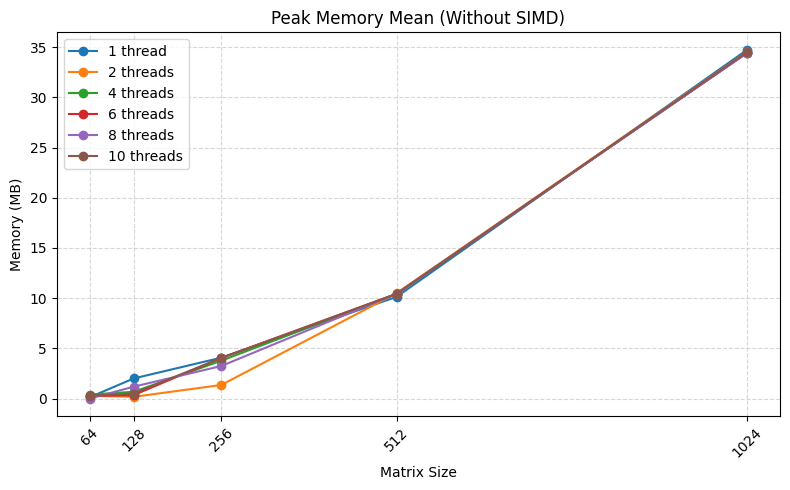

Plot saved to ./graphs\peak_mem_mb_median_absolute_without_simd.png


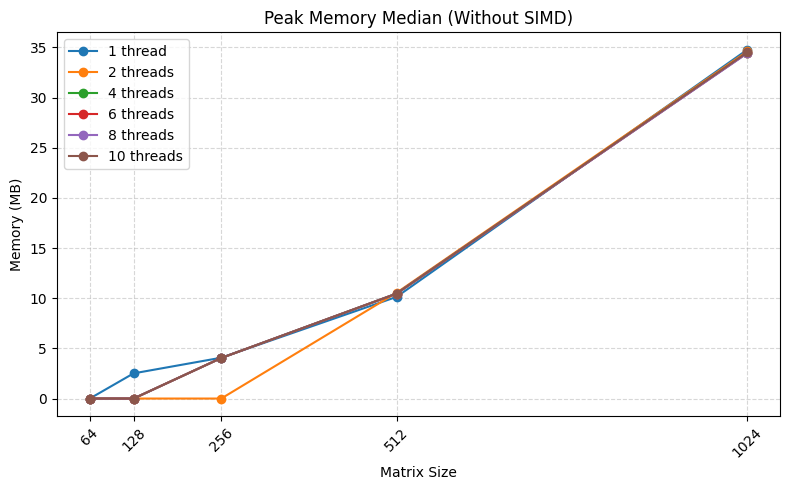

Plot saved to ./graphs\peak_mem_mb_std_absolute_without_simd.png


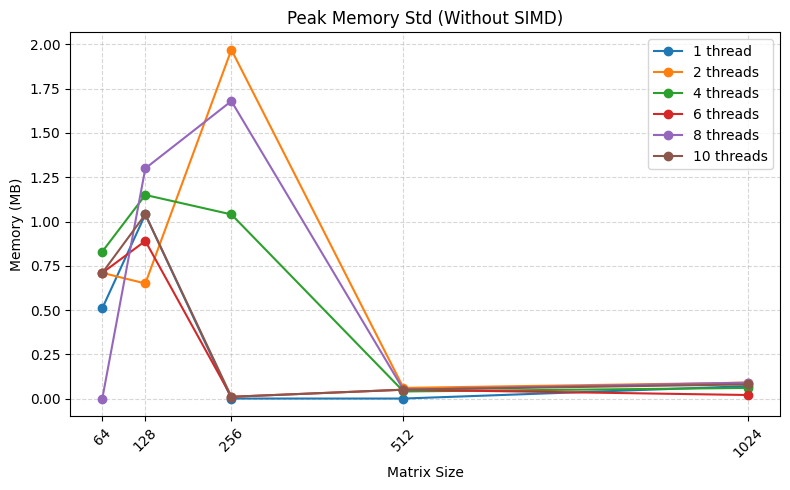

{'peak_mem_mb_mean':     matrix_size  threads  value
 0            64        1   0.13
 1           128        1   2.00
 2           256        1   4.07
 3           512        1  10.13
 4          1024        1  34.75
 5            64        2   0.27
 6           128        2   0.17
 7           256        2   1.35
 8           512        2  10.50
 9          1024        2  34.55
 10           64        4   0.40
 11          128        4   0.67
 12          256        4   3.77
 13          512        4  10.42
 14         1024        4  34.46
 15           64        6   0.27
 16          128        6   0.34
 17          256        6   4.04
 18          512        6  10.43
 19         1024        6  34.44
 20           64        8   0.00
 21          128        8   1.18
 22          256        8   3.24
 23          512        8  10.45
 24         1024        8  34.44
 25           64       10   0.27
 26          128       10   0.50
 27          256       10   4.04
 28          512       

In [11]:
# Preparar variables
matrix_sizes = sorted(agg_df['matrix_size'].unique())
thread_counts = sorted(agg_df['threads'].unique())

# Columnas de peak memory que queremos graficar
metrics = ['peak_mem_mb_mean', 'peak_mem_mb_median', 'peak_mem_mb_std']
titles = ['Peak Memory Mean (Without SIMD)', 
        'Peak Memory Median (Without SIMD)', 
        'Peak Memory Std (Without SIMD)']
y_labels = ['Memory (MB)'] * len(metrics)

# Diccionario donde guardaremos una tabla por métrica
tables_by_metric = {}

# Graficar cada métrica de peak memory sin SIMD
for metric, title, y_label in zip(metrics, titles, y_labels):

    rows = []  # tabla para este gráfico
    y_lines = []
    labels = []

    for t in thread_counts:
        y_values = []

        for size in matrix_sizes:

            mem_value = agg_df[
                (agg_df['matrix_size'] == size) &
                (agg_df['threads'] == t) &
                (agg_df['vectorization'] == 'none')
            ][metric].mean()

            y_values.append(mem_value)

            # Añadir fila a la tabla
            rows.append({
                "matrix_size": size,
                "threads": t,
                "value": mem_value
            })

        y_lines.append(y_values)
        labels.append(f"{t} thread{'s' if t > 1 else ''}")

    # Guardar DataFrame de esta métrica
    tables_by_metric[metric] = pd.DataFrame(rows)

    # Graficar
    plot_lines(
        x=matrix_sizes,
        y=y_lines,
        file_name=f"{metric}_absolute_without_simd.png",
        labels=labels,
        title=title,
        xlabel="Matrix Size",
        ylabel=y_label,
        markers=True
    )

# Resultado: un diccionario con una tabla por métrica
tables_by_metric


Plot saved to ./graphs\allocmem_with_baseline.png


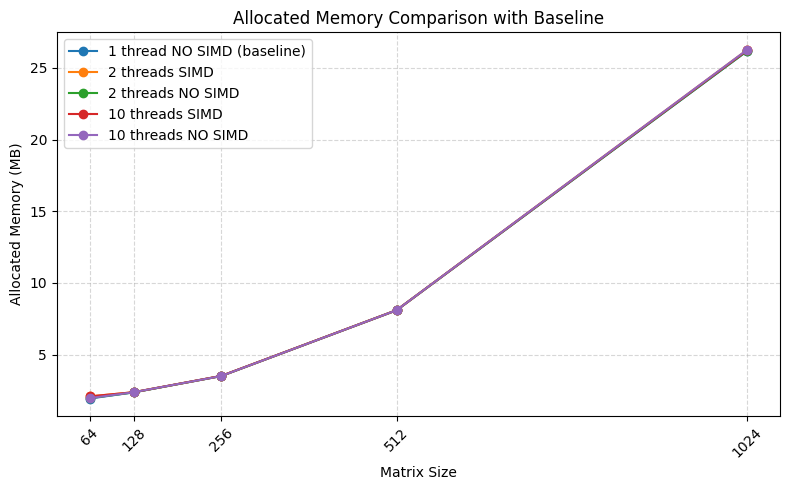

   matrix_size  baseline_1thread_none_MB  alloc_simd_2_MB  alloc_none_2_MB  \
0           64                      1.94             2.09             1.97   
1          128                      2.37             2.38             2.37   
2          256                      3.51             3.51             3.51   
3          512                      8.09             8.10             8.10   
4         1024                     26.17            26.25            26.18   

   alloc_simd_10_MB  alloc_none_10_MB  
0              2.09              1.97  
1              2.38              2.38  
2              3.52              3.51  
3              8.10              8.10  
4             26.22             26.26  


In [24]:
# Preparar variables
matrix_sizes = sorted(agg_df['matrix_size'].unique())

metric = "alloc_mem_mb_mean"

baseline_1thread_none = []
alloc_simd_2 = []
alloc_none_2 = []
alloc_simd_10 = []
alloc_none_10 = []

for size in matrix_sizes:

    # Baseline: 1 thread, no SIMD
    df_none = agg_df[(agg_df["matrix_size"] == size) & (agg_df["vectorization"] == "none")]
    t1_none = df_none[df_none["threads"] == 1][metric].mean()
    baseline_1thread_none.append(t1_none)

    # SIMD
    df_simd = agg_df[(agg_df["matrix_size"] == size) & (agg_df["vectorization"] == "simd")]
    alloc_simd_2.append(df_simd[df_simd["threads"] == 2][metric].mean())
    alloc_simd_10.append(df_simd[df_simd["threads"] == 10][metric].mean())

    # NONE
    alloc_none_2.append(df_none[df_none["threads"] == 2][metric].mean())
    alloc_none_10.append(df_none[df_none["threads"] == 10][metric].mean())

# ----------------------------------------------------------------------
# Graficar comparación combinada con baseline
# ----------------------------------------------------------------------

plot_lines(
    x=matrix_sizes,
    y=[
        baseline_1thread_none,
        alloc_simd_2,
        alloc_none_2,
        alloc_simd_10,
        alloc_none_10
    ],
    labels=[
        "1 thread NO SIMD (baseline)",
        "2 threads SIMD",
        "2 threads NO SIMD",
        "10 threads SIMD",
        "10 threads NO SIMD"
    ],
    file_name="allocmem_with_baseline.png",
    title="Allocated Memory Comparison with Baseline",
    xlabel="Matrix Size",
    ylabel="Allocated Memory (MB)",
    markers=True
)

# ----------------------------------------------------------------------
# Tabla con los datos usados
# ----------------------------------------------------------------------

comparison_table = pd.DataFrame({
    "matrix_size": matrix_sizes,
    "baseline_1thread_none_MB": baseline_1thread_none,
    "alloc_simd_2_MB": alloc_simd_2,
    "alloc_none_2_MB": alloc_none_2,
    "alloc_simd_10_MB": alloc_simd_10,
    "alloc_none_10_MB": alloc_none_10
})

print(comparison_table)


Plot saved to ./graphs\peakmem_with_baseline.png


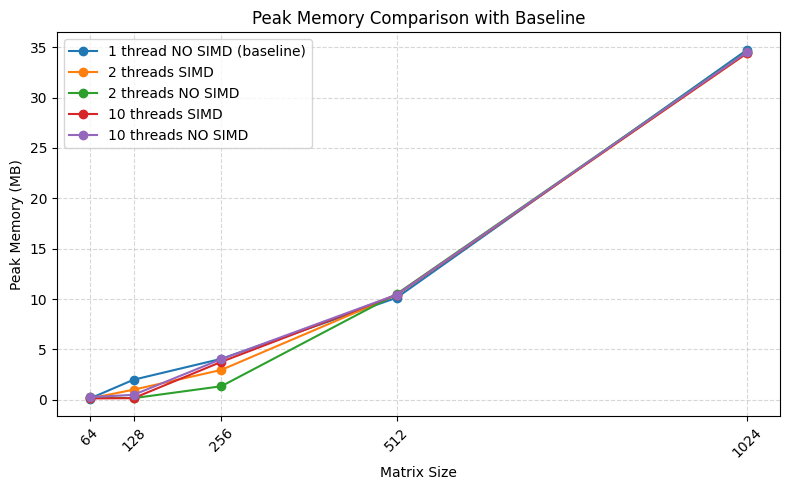

   matrix_size  baseline_1thread_none_MB  peak_simd_2_MB  peak_none_2_MB  \
0           64                      0.13            0.14            0.27   
1          128                      2.00            1.01            0.17   
2          256                      4.07            2.97            1.35   
3          512                     10.13           10.41           10.50   
4         1024                     34.75           34.42           34.55   

   peak_simd_10_MB  peak_none_10_MB  
0             0.14             0.27  
1             0.17             0.50  
2             3.77             4.04  
3            10.43            10.43  
4            34.43            34.53  


In [25]:
# Preparar variables
matrix_sizes = sorted(agg_df['matrix_size'].unique())

metric = "peak_mem_mb_mean"

baseline_1thread_none = []
peak_simd_2 = []
peak_none_2 = []
peak_simd_10 = []
peak_none_10 = []

for size in matrix_sizes:

    # Baseline: 1 thread, no SIMD
    df_none = agg_df[(agg_df["matrix_size"] == size) & (agg_df["vectorization"] == "none")]
    t1_none = df_none[df_none["threads"] == 1][metric].mean()
    baseline_1thread_none.append(t1_none)

    # SIMD
    df_simd = agg_df[(agg_df["matrix_size"] == size) & (agg_df["vectorization"] == "simd")]
    peak_simd_2.append(df_simd[df_simd["threads"] == 2][metric].mean())
    peak_simd_10.append(df_simd[df_simd["threads"] == 10][metric].mean())

    # NONE
    peak_none_2.append(df_none[df_none["threads"] == 2][metric].mean())
    peak_none_10.append(df_none[df_none["threads"] == 10][metric].mean())

# ----------------------------------------------------------------------
# Graficar comparación combinada con baseline
# ----------------------------------------------------------------------

plot_lines(
    x=matrix_sizes,
    y=[
        baseline_1thread_none,
        peak_simd_2,
        peak_none_2,
        peak_simd_10,
        peak_none_10
    ],
    labels=[
        "1 thread NO SIMD (baseline)",
        "2 threads SIMD",
        "2 threads NO SIMD",
        "10 threads SIMD",
        "10 threads NO SIMD"
    ],
    file_name="peakmem_with_baseline.png",
    title="Peak Memory Comparison with Baseline",
    xlabel="Matrix Size",
    ylabel="Peak Memory (MB)",
    markers=True
)

# ----------------------------------------------------------------------
# Tabla con los datos usados
# ----------------------------------------------------------------------

comparison_table = pd.DataFrame({
    "matrix_size": matrix_sizes,
    "baseline_1thread_none_MB": baseline_1thread_none,
    "peak_simd_2_MB": peak_simd_2,
    "peak_none_2_MB": peak_none_2,
    "peak_simd_10_MB": peak_simd_10,
    "peak_none_10_MB": peak_none_10
})

print(comparison_table)


% CPU usage

Plot saved to ./graphs\cpu_usage_percent_mean_absolute_simd.png


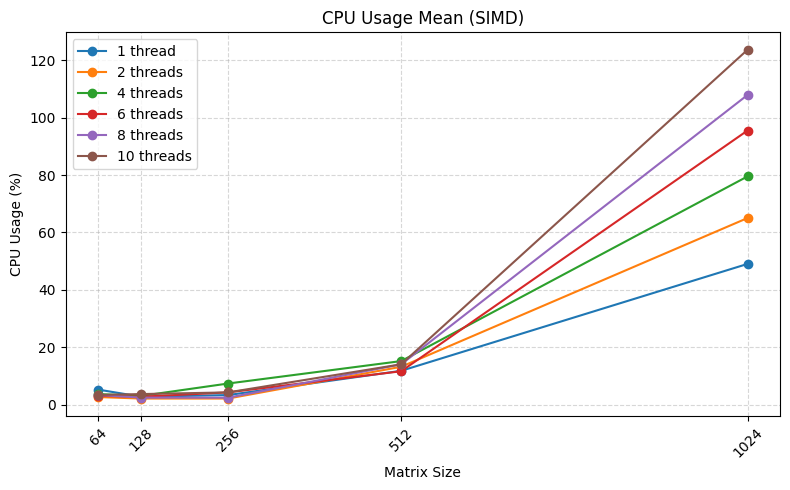

Plot saved to ./graphs\cpu_usage_percent_median_absolute_simd.png


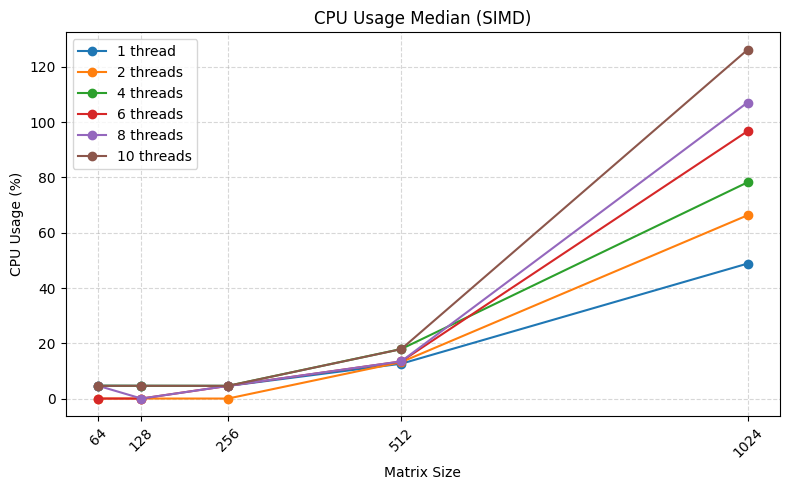

Plot saved to ./graphs\cpu_usage_percent_std_absolute_simd.png


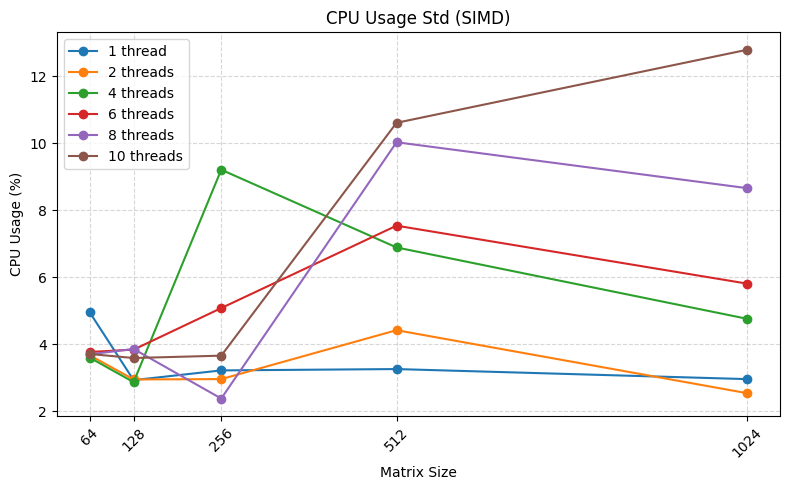

[{'matrix_size': np.int64(64),
  'threads': np.int64(1),
  'value': np.float64(5.27)},
 {'matrix_size': np.int64(128),
  'threads': np.int64(1),
  'value': np.float64(2.78)},
 {'matrix_size': np.int64(256),
  'threads': np.int64(1),
  'value': np.float64(3.36)},
 {'matrix_size': np.int64(512),
  'threads': np.int64(1),
  'value': np.float64(11.81)},
 {'matrix_size': np.int64(1024),
  'threads': np.int64(1),
  'value': np.float64(49.04)},
 {'matrix_size': np.int64(64),
  'threads': np.int64(2),
  'value': np.float64(2.67)},
 {'matrix_size': np.int64(128),
  'threads': np.int64(2),
  'value': np.float64(2.15)},
 {'matrix_size': np.int64(256),
  'threads': np.int64(2),
  'value': np.float64(2.15)},
 {'matrix_size': np.int64(512),
  'threads': np.int64(2),
  'value': np.float64(13.22)},
 {'matrix_size': np.int64(1024),
  'threads': np.int64(2),
  'value': np.float64(65.02)},
 {'matrix_size': np.int64(64),
  'threads': np.int64(4),
  'value': np.float64(3.71)},
 {'matrix_size': np.int64(128

In [15]:
# Preparar variables
matrix_sizes = sorted(agg_df['matrix_size'].unique())
thread_counts = sorted(agg_df['threads'].unique())

# Columnas de uso de CPU que queremos graficar
metrics = ['cpu_usage_percent_mean', 'cpu_usage_percent_median', 'cpu_usage_percent_std']
titles = ['CPU Usage Mean (SIMD)', 'CPU Usage Median (SIMD)', 'CPU Usage Std (SIMD)']
y_labels = ['CPU Usage (%)'] * len(metrics)

# Diccionario para guardar una tabla por cada métrica
tables_by_metric = {}

# Graficar cada métrica de CPU con SIMD
for metric, title, y_label in zip(metrics, titles, y_labels):

    rows = []  # <-- tabla para ESTA métrica

    y_lines = []
    labels = []

    for t in thread_counts:
        y_values = []

        for size in matrix_sizes:
            # Filtrar por tamaño, threads y SIMD
            cpu_value = agg_df[
                (agg_df['matrix_size'] == size) &
                (agg_df['threads'] == t) &
                (agg_df['vectorization'] == 'simd')
            ][metric].mean()  # promedio si hay múltiples registros

            y_values.append(cpu_value)

            # Agregar fila a ESTA tabla
            rows.append({
                "matrix_size": size,
                "threads": t,
                "value": cpu_value
            })

        y_lines.append(y_values)
        labels.append(f"{t} thread{'s' if t > 1 else ''}")

    # Guardar la tabla en el diccionario
    tables_by_metric[metric] = rows  # plain list of dicts; you can convert to DataFrame if needed

    # Llamar a la función plot_lines
    plot_lines(
        x=matrix_sizes,
        y=y_lines,
        file_name=f"{metric}_absolute_simd.png",
        labels=labels,
        title=title,
        xlabel="Matrix Size",
        ylabel=y_label,
        markers=True
    )

# ---> tables_by_metric now contains one table (list of dicts) per metric
# Example access:
tables_by_metric['cpu_usage_percent_mean']


Plot saved to ./graphs\cpu_usage_percent_mean_absolute_without_simd.png


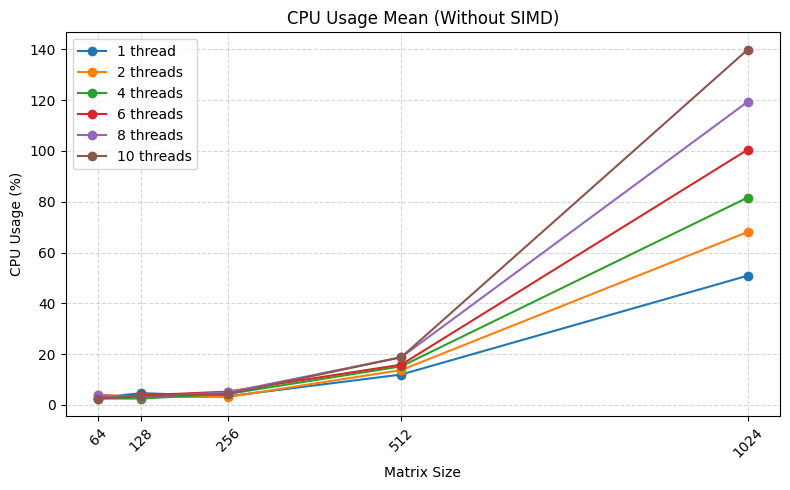

Plot saved to ./graphs\cpu_usage_percent_median_absolute_without_simd.png


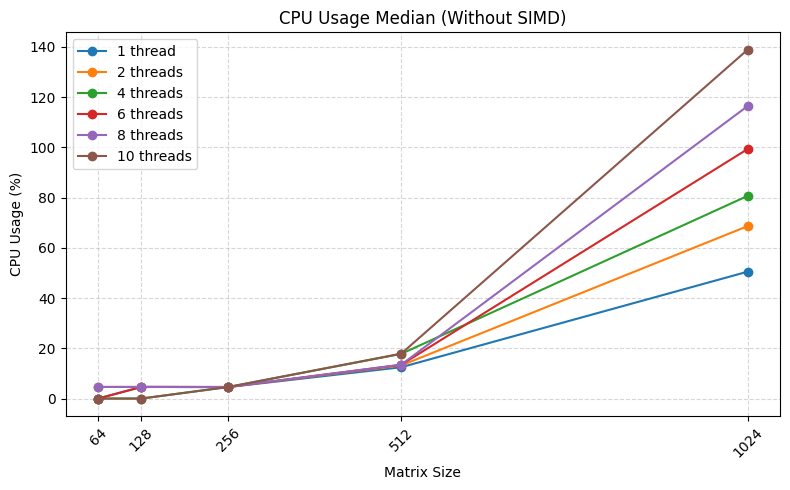

Plot saved to ./graphs\cpu_usage_percent_std_absolute_without_simd.png


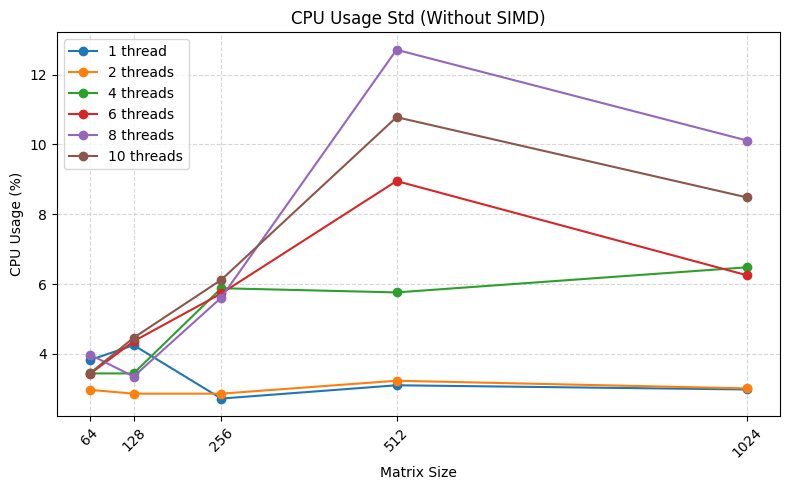

{'cpu_usage_percent_mean':     matrix_size  threads  cpu_value
 0            64        1       2.78
 1           128        1       4.60
 2           256        1       3.36
 3           512        1      11.93
 4          1024        1      50.85
 5            64        2       4.02
 6           128        2       3.09
 7           256        2       3.08
 8           512        2      13.69
 9          1024        2      68.06
 10           64        4       2.47
 11          128        4       2.47
 12          256        4       4.29
 13          512        4      15.14
 14         1024        4      81.62
 15           64        6       2.78
 16          128        6       3.71
 17          256        6       5.21
 18          512        6      15.81
 19         1024        6     100.47
 20           64        8       3.70
 21          128        8       3.09
 22          256        8       4.90
 23          512        8      18.74
 24         1024        8     119.34
 25         

In [16]:
# Preparar variables
matrix_sizes = sorted(agg_df['matrix_size'].unique())
thread_counts = sorted(agg_df['threads'].unique())

# Columnas de uso de CPU que queremos graficar
metrics = ['cpu_usage_percent_mean', 'cpu_usage_percent_median', 'cpu_usage_percent_std']
titles = ['CPU Usage Mean (Without SIMD)', 'CPU Usage Median (Without SIMD)', 'CPU Usage Std (Without SIMD)']
y_labels = ['CPU Usage (%)'] * len(metrics)

# Diccionario para guardar una tabla por cada métrica
tables_by_metric = {}

# Graficar cada métrica de CPU sin SIMD
for metric, title, y_label in zip(metrics, titles, y_labels):

    rows = []   # <-- tabla para ESTA métrica

    y_lines = []
    labels = []

    for t in thread_counts:
        y_values = []

        for size in matrix_sizes:
            # Filtrar por tamaño, threads y sin SIMD
            cpu_value = agg_df[
                (agg_df['matrix_size'] == size) &
                (agg_df['threads'] == t) &
                (agg_df['vectorization'] == 'none')
            ][metric].mean()  # promedio si hay múltiples registros

            y_values.append(cpu_value)

            # Agregar fila a ESTA tabla
            rows.append({
                "matrix_size": size,
                "threads": t,
                "cpu_value": cpu_value
            })

        y_lines.append(y_values)
        labels.append(f"{t} thread{'s' if t > 1 else ''}")

    # Guardar la tabla en un DataFrame
    tables_by_metric[metric] = pd.DataFrame(rows)

    # Graficar
    plot_lines(
        x=matrix_sizes,
        y=y_lines,
        file_name=f"{metric}_absolute_without_simd.png",
        labels=labels,
        title=title,
        xlabel="Matrix Size",
        ylabel=y_label,
        markers=True
    )

# ---> tables_by_metric now contains a table for each CPU metric
tables_by_metric


Plot saved to ./graphs\cpu_usage_with_baseline.png


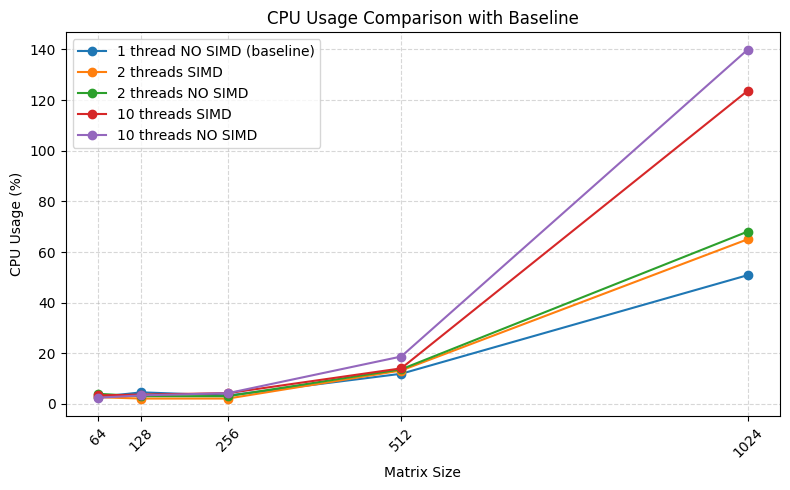

   matrix_size  baseline_1thread_none_percent  cpu_simd_2_percent  \
0           64                           2.78                2.67   
1          128                           4.60                2.15   
2          256                           3.36                2.15   
3          512                          11.93               13.22   
4         1024                          50.85               65.02   

   cpu_none_2_percent  cpu_simd_10_percent  cpu_none_10_percent  
0                4.02                 3.40                 2.47  
1                3.09                 3.71                 3.40  
2                3.08                 4.29                 4.28  
3               13.69                14.07                18.74  
4               68.06               123.63               139.87  


In [26]:
# Preparar variables
matrix_sizes = sorted(agg_df['matrix_size'].unique())

metric = "cpu_usage_percent_mean"

baseline_1thread_none = []
cpu_simd_2 = []
cpu_none_2 = []
cpu_simd_10 = []
cpu_none_10 = []

for size in matrix_sizes:

    # Baseline: 1 thread, no SIMD
    df_none = agg_df[(agg_df["matrix_size"] == size) & (agg_df["vectorization"] == "none")]
    t1_none = df_none[df_none["threads"] == 1][metric].mean()
    baseline_1thread_none.append(t1_none)

    # SIMD
    df_simd = agg_df[(agg_df["matrix_size"] == size) & (agg_df["vectorization"] == "simd")]
    cpu_simd_2.append(df_simd[df_simd["threads"] == 2][metric].mean())
    cpu_simd_10.append(df_simd[df_simd["threads"] == 10][metric].mean())

    # NONE
    cpu_none_2.append(df_none[df_none["threads"] == 2][metric].mean())
    cpu_none_10.append(df_none[df_none["threads"] == 10][metric].mean())

# ----------------------------------------------------------------------
# Graficar comparación combinada con baseline
# ----------------------------------------------------------------------

plot_lines(
    x=matrix_sizes,
    y=[
        baseline_1thread_none,
        cpu_simd_2,
        cpu_none_2,
        cpu_simd_10,
        cpu_none_10
    ],
    labels=[
        "1 thread NO SIMD (baseline)",
        "2 threads SIMD",
        "2 threads NO SIMD",
        "10 threads SIMD",
        "10 threads NO SIMD"
    ],
    file_name="cpu_usage_with_baseline.png",
    title="CPU Usage Comparison with Baseline",
    xlabel="Matrix Size",
    ylabel="CPU Usage (%)",
    markers=True
)

# ----------------------------------------------------------------------
# Tabla con los datos usados
# ----------------------------------------------------------------------

comparison_table = pd.DataFrame({
    "matrix_size": matrix_sizes,
    "baseline_1thread_none_percent": baseline_1thread_none,
    "cpu_simd_2_percent": cpu_simd_2,
    "cpu_none_2_percent": cpu_none_2,
    "cpu_simd_10_percent": cpu_simd_10,
    "cpu_none_10_percent": cpu_none_10
})

print(comparison_table)
